In [1]:
import numpy as np
import sys
from scipy.linalg import expm
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi


In [2]:
def create_single_hopping_fermionic_operator(i, j, N):
    if i > j:
        raise ValueError("i must be smaller or equal to j")
    else:
        L = 2**N
        H = np.zeros((L,L))
        if i!=j:
            for k in range(L):
                state = list(np.binary_repr(k, N))
                if state[i] == "0" and state[j] == "1":
                    counter = 1
                    for l in range(i, j):
                        cur_str = state[l]
                        if cur_str == "1":
                            counter *= -1
                    new_state = state.copy()
                    new_state[i] = "1"
                    new_state[j] = "0"
                    new_state = "".join(new_state)
                    new_state = int(new_state, 2)
                    H[new_state, k] = counter
        else:
            for k in range(L):
                state = list(np.binary_repr(k, N))
                if state[i] == "1":
                    H[k, k] = 1
    H = H - H.transpose()
    return H

def create_single_hopping_fermionic_operator_test(i, j, N):
    if i > j:
        raise ValueError("i must be smaller or equal to j")
    else:
        L = 2**N
        H = np.zeros((L,L))
        if i!=j:
            for k in range(L):
                state = list(np.binary_repr(k, N))
                "(a^+_i a_j)"
                if state[i] == "0" and state[j] == "1":
                    counter = 1
                    for l in range(i, j):
                        cur_str = state[l]
                        if cur_str == "1":
                            counter *= -1
                    new_state = state.copy()
                    new_state[i] = "1"
                    new_state[j] = "0"
                    new_state = "".join(new_state)
                    new_state = int(new_state, 2)
                    H[new_state, k] = counter
                "-(a^+_j a_i)"
                if state[j] == "0" and state[i] == "1":
                    counter = -1
                    for l in range(i+1, j):
                        cur_str = state[l]
                        if cur_str == "1":
                            counter *= -1
                    
                    new_state = state.copy()
                    new_state[i] = "0"
                    new_state[j] = "1"
                    new_state = "".join(new_state)
                    # print(state, "old")
                    # print(new_state, "new")
                    # print(counter)
                    # print("=====")
                    new_state = int(new_state, 2)
                    H[new_state, k] = counter
        else:
            for k in range(L):
                state = list(np.binary_repr(k, N))
                if state[i] == "1":
                    H[k, k] = 1
    return H

In [37]:
i = 0
j = 4
N = 5
H = create_single_hopping_fermionic_operator(i,j,N)
H1 = create_single_hopping_fermionic_operator_test(i,j,N)
print(f"The size of system is {N}, i={i}, j={j}")
print(f"The difference between H and H1 is {np.sum(abs(H-H1))}")
# print(H)
# print(H1)


The size of system is 5, i=0, j=4
The difference between H and H1 is 0.0


In [40]:
t = 1
ops = FermionicOp({"+_" + str(i)+" -_"+str(j): t, "+_" + str(j)+" -_"+str(i):-t}, num_spin_orbitals=N)
mapper = JordanWignerMapper()
jw_op = mapper.map(ops)
jw_op = qi.Operator(jw_op).to_matrix()
jw_op = np.array(jw_op)
eigH = np.linalg.eig(H)[0]
eigJW = np.linalg.eig(jw_op)[0]
eigH = np.sort(1j*eigH)
eigJW = np.sort(1j*eigJW)
print(f"The norm of the eigenvalue of qubit matrix is {np.linalg.norm(eigH)}")
print(f"The norm of the eigenvalue of the JW transformation from Qiskit is {np.linalg.norm(eigJW)}")
print(f"The difference between two eigenvalue vector is {np.sum(abs(eigH - eigJW))}")

The norm of the eigenvalue of qubit matrix is 4.0
The norm of the eigenvalue of the JW transformation from Qiskit is 3.999999999999999
The difference between two eigenvalue vector is 2.886579864025407e-15


In [138]:
def create_single_hopping_qubit_operator(i,j,N):
    if i>j:
        raise ValueError("i must be smaller or equal to j")
    L = 2**N
    H = np.zeros((L,L))
    for k in range(L):
        state = list(np.binary_repr(k, N))
        if state[i] == "0" and state[j] == "1":
            counter = 1
            for l in range(i, j):
                cur_str = state[l]
                if cur_str == "1":
                    counter *= -1
            new_state = state.copy()
            new_state[i] = "1"
            new_state[j] = "0"
            new_state = "".join(new_state)
            new_state = int(new_state, 2)
            H[new_state, k] = counter
    H = H - H.transpose()
    return H

In [139]:
def create_single_hopping_qubit_exponent(N, i, j, t):
    y = np.array([[0, -1j], [1j, 0]])
    x = np.array([[0, 1], [1, 0]])
    z = np.array([[1, 0], [0, -1]])
    I = np.eye(2)
    A = 1
    B = 1
    for k in range(N):
        if k < i:
            A = np.kron(A, I)
            B = np.kron(B,I)
        elif k == i:
            A = np.kron(A, -t*1j*y/2)
            B = np.kron(B, t*1j*x/2)
        elif k < j:
            A = np.kron(A, z)
            B = np.kron(B, z)
        elif k == j:
            A = np.kron(A, x)
            B = np.kron(B, y)
        else:
            A = np.kron(A, I)
            B = np.kron(B,I)
    A_test = np.kron(-1j*y/2,x)
    return np.matmul(expm(A), expm(B))



In [140]:
y = np.array([[0, -1j], [1j, 0]])
x = np.array([[0, 1], [1, 0]])
z = np.array([[1, 0], [0, -1]])
I = np.eye(2)
A = np.kron(-1j*y/2,x)
B = np.kron(1j*x/2, y)
A = np.kron(A,I)
B = np.kron(B,I)
testH = np.matmul(expm(A), expm(B))

i = 0
j = 1
N = 3
t = 1
expH = create_single_hopping_qubit_exponent(N, i, j, t)
print(abs(expH-testH))

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:

def construct_circuit(i,j,N,t):
    # Construc before hand gates
    qc = QuantumCircuit(N)
    qc.h(N-j-1)
    
    qc.sdg(N - i - 1)
    qc.h(N - i - 1)

    for k in range(i,j):
        qc.cx(N - k - 1, N - (k+1) - 1)
    qc.rz(t, N-j-1)
    for k in range(j,i,-1):
        qc.cx(N-k, N-k-1)

    qc.h(N-i-1)    
    qc.s(N-i-1)
    qc.h(N-j-1)
    
    # Construc the second term
    qc.h(N-i-1)
    
    qc.sdg(N-j-1)
    qc.h(N-j-1)

    for k in range(i,j):
        qc.cx(N-k-1, N-k-2)
    qc.rz(-t, N-j-1)
    for k in range(j,i,-1):
        qc.cx(N-k, N-k-1)

    qc.h(N-j-1)    
    qc.s(N-j-1)
    qc.h(N-i-1)
    return qc

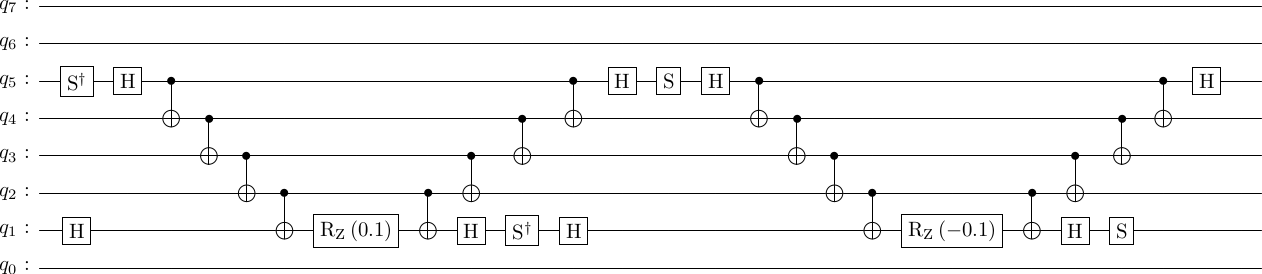

In [142]:
i = 2
j = 6
N = 8
t = 0.1
expH = create_single_hopping_qubit_exponent(N, i, j, t)
qc = construct_circuit(i,j,N,t)
qc.draw(reverse_bits=True)
M = qi.Operator(qc).to_matrix()
M = np.array(M)
from IPython.display import display
display(qc.draw("latex", reverse_bits=True))


In [143]:
# print(f"The qubit matrix is\n {np.real(expH)}")
# print(f"cos(1) = {np.cos(1)}")
print(f"The difference between the matrix of the circuit and the qubit matrix is {np.sum(abs(expH-M))}")

The difference between the matrix of the circuit and the qubit matrix is 1.9362345049050105e-13


In [144]:
test = QuantumCircuit(1)
# test.sdg(0)
# test.h(0)
# test.z(0)
# test.h(0)
# test.s(0)
test.h(0)
test.x(0)
test.h(0)
m = qi.Operator(test)
print(m)
print(test)

Operator([[ 1.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j]],
         input_dims=(2,), output_dims=(2,))
   ┌───┐┌───┐┌───┐
q: ┤ H ├┤ X ├┤ H ├
   └───┘└───┘└───┘


In [145]:
N = 2
qc = QuantumCircuit(N)
i = 0
j = 1
for k in range(i,j):
    qc.cx(k, k+1)
qc.rz(-1, j)
for k in range(j,i,-1):
    qc.cx(k-1, k)
print(qc)
m = qi.Operator(qc)
print(m)


                         
q_0: ──■──────────────■──
     ┌─┴─┐┌────────┐┌─┴─┐
q_1: ┤ X ├┤ Rz(-1) ├┤ X ├
     └───┘└────────┘└───┘
Operator([[0.87758256+0.47942554j, 0.        +0.j        ,
           0.        +0.j        , 0.        +0.j        ],
          [0.        +0.j        , 0.87758256-0.47942554j,
           0.        +0.j        , 0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
           0.87758256-0.47942554j, 0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
           0.        +0.j        , 0.87758256+0.47942554j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [146]:

N = 2
qc = QuantumCircuit(N)
qc.x(1)
qc.z(0)
print(qc)
print(f"The original matrix of XZ is {np.kron(x,z)}")
print(f"The matrix of the circuit of XZ is {np.real(qi.Operator(qc))}")

     ┌───┐
q_0: ┤ Z ├
     ├───┤
q_1: ┤ X ├
     └───┘
The original matrix of XZ is [[ 0  0  1  0]
 [ 0  0  0 -1]
 [ 1  0  0  0]
 [ 0 -1  0  0]]
The matrix of the circuit of XZ is [[ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]
 [ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]]


In [72]:
def create_double_hopping_fermionic_operator(i, j, k, m, N):
    if i > j or j > k or k > m:
        raise ValueError("please order your index")
    else:
        L = 2**N
        H = np.zeros((L,L))
        if i!=j:
            for num in range(L):
                state = list(np.binary_repr(num, N))
                if state[i] == "0" and state[j] == "0" and state[k] == "1" and state[m] == "1":
                    counter = -1
                    for l in range(i, j):
                        cur_str = state[l]
                        if cur_str == "1":
                            counter *= -1
                    for l in range(k,m):
                        cur_str = state[l]
                        if cur_str == "1":
                            counter *= -1
                    new_state = state.copy()
                    new_state[i] = "1"
                    new_state[j] = "1"
                    new_state[k] = "0"
                    new_state[m] = "0"
                    new_state = "".join(new_state)
                    new_state = int(new_state, 2)
                    H[new_state, num] = counter
        else:
            for k in range(L):
                state = list(np.binary_repr(k, N))
                if state[i] == "1":
                    H[k, k] = 1
    H = H - H.transpose()
    return H

In [75]:
i = 0
j = 1
k = 3
m = 5
N = 7
t = 1
ops = FermionicOp({"+_" + str(i)+" +_"+str(j)+ " -_" + str(k)+" -_"+str(m) : t,\
                    "+_" + str(m)+" +_"+str(k)+ " -_" + str(j)+" -_"+str(i):-t}, num_spin_orbitals=N)
mapper = JordanWignerMapper()
jw_op = mapper.map(ops)
jw_op = qi.Operator(jw_op).to_matrix()
jw_op = np.array(jw_op)

H = create_double_hopping_fermionic_operator(i, j, k, m, N)
print(ops)
eigH = np.linalg.eig(H)[0]
eigJW = np.linalg.eig(jw_op)[0]
eigH = np.sort(1j*eigH)
eigJW = np.sort(1j*eigJW)
print(f"i = {i}, j = {j}, k = {k}, m = {m}, N = {N}")
print(f"The norm of the eigenvalue of qubit matrix is {np.linalg.norm(eigH)}")
print(f"The norm of the eigenvalue of the JW transformation from Qiskit is {np.linalg.norm(eigJW)}")
print(f"The difference between two eigenvalue vector is {np.sum(abs(eigH - eigJW))}")

Fermionic Operator
number spin orbitals=7, number terms=2
  1 * ( +_0 +_1 -_3 -_5 )
+ -1 * ( +_5 +_3 -_1 -_0 )
i = 0, j = 1, k = 3, m = 5, N = 7
The norm of the eigenvalue of qubit matrix is 4.0
The norm of the eigenvalue of the JW transformation from Qiskit is 3.999999999999999
The difference between two eigenvalue vector is 2.886579864025407e-15
